In [1]:
!pip install pandas_ta
!pip install neat-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=c41efd9e8a7e21f7cb05781aa748e9e90d00ccf3d57735f50da2a818a430cf8a
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 3.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
use_collab = True
if use_collab:
  csv_dir = '/content/drive/MyDrive/eurusd_hour.csv'
  config_dir = '/content/drive/MyDrive/config-feedforward'
else:
  csv_dir = '/tmp/eurusd_hour.csv'
  config_dir = '/tmp/config-feedforward'

In [4]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
import random
import neat
import string

In [5]:
def get_relative_change(df, column_name):
    relative_changes = []
    for i in range(len(df)):
        if i == 0:
            relative_changes.append(0)  # First element has no previous value
        else:
            relative_change = (df.iloc[i] - df.iloc[i-1]) / df.iloc[i-1]
            relative_changes.append(relative_change)
    return pd.DataFrame({column_name: relative_changes})

In [6]:
df = pd.read_csv(csv_dir)
close = df['AC']
open = df['AO']
high = df['AH']
low = df['AL']


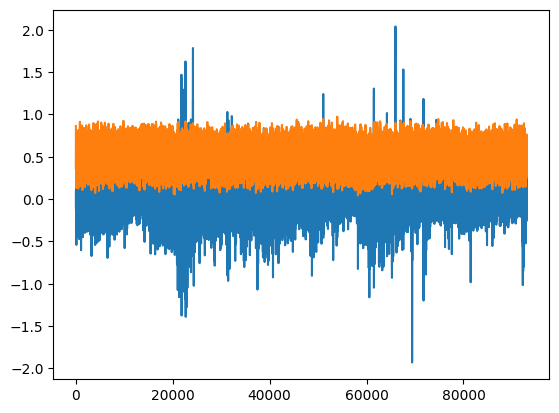

In [7]:
close_np = close.to_numpy()


# Calculate the rolling velocity
RSI = ta.rsi(close,10,scalar=1)
ROC = ta.roc(close,8,scalar=50)
CHANGE = get_relative_change(close,"Change")

INDICATORS = pd.concat([ROC,RSI,CHANGE],axis=1)

INDICATORS = INDICATORS.dropna(axis=0)
INDICATORS = INDICATORS.reset_index()
INDICATORS.pop('index')

change = INDICATORS.pop('Change')
INDICATORS = INDICATORS.to_numpy()
change = change.to_numpy()
change_dev = change.std()
change = change/change_dev


plt.plot(INDICATORS)

In [8]:
def softmax(x):
    y = np.exp(x - np.max(x))
    f_x = y / np.sum(np.exp(x))
    return f_x

In [9]:
def clamp(num, min_value, max_value):
    return max(min(num, max_value), min_value)

In [10]:
outputs = [.6,.7,.8,.10]
action = outputs[:3]
maxed = np.argmax(action)
print(maxed)

2


In [11]:
def run_env_loop(net,rand,debug):
    trade_info = np.zeros(4)
    returns = np.array([])

    trade_timer = 0
    trade_value = 0
    trade_direction = 0
    trade_max = 0
    cash_out_val = 0


    for count in range(rand, rand+1000):
        state = np.concatenate((INDICATORS[count], trade_info))
        outputs = net.activate(state)
        action = np.argmax(outputs)
        buy = True if action == 3 else False
        sell = True if action == 2 else False
        cash_out = True if action == 0 else False
        cur_move = change[count]

        if buy or sell:
          cash_out_value = trade_value
          trade_direction = 1 if buy else -1
          trade_value = ((cur_move*trade_direction)-.1)
          trade_max = trade_value
          trade_timer = 0
        elif cash_out:
          cash_out_value = trade_value
          trade_direction = 0
          trade_value = 0
          trade_max = 0
          trade_timer = 0
        else:
          cash_out_value = 0
          trade_value += cur_move*trade_direction if trade_direction != 0 else 0
          trade_max = max(trade_max,trade_value)
          trade_timer += .1


        trade_info = np.array((trade_direction,trade_value,trade_timer,trade_max))

        if cash_out_value != 0:
            returns = np.append(returns,cash_out_value)
        if debug:
          print(trade_info)
          print(cash_out_value)

    return np.sum(returns) if len(returns)>1 else 0

In [12]:
def eval_genomes(genomes, config):
  rand = random.randint(0, 70000)
  for genome_id, genome in genomes:
    genome.fitness = 0.0
    net = neat.nn.FeedForwardNetwork.create(genome, config)
    genome.fitness = run_env_loop(net,rand,False)


In [13]:
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_dir)

p = neat.Population(config)
p.add_reporter(neat.StdOutReporter(False))
#p.add_reporter(neat.Checkpointer(100, 100,filename_prefix="/content/drive/MyDrive/neat/Neetcheckpoint/"))

In [14]:
winner = p.run(eval_genomes,10)


 ****** Running generation 0 ****** 

Population's average fitness: 0.00000 stdev: 0.00000
Best fitness: 0.00000 - size: (4, 0) - species 1 - id 1
Average adjusted fitness: 0.000
Mean genetic distance 0.735, standard deviation 0.438
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 10.189 sec

 ****** Running generation 1 ****** 

Population's average fitness: -1.97743 stdev: 22.56843
Best fitness: 113.03253 - size: (4, 1) - species 1 - id 189
Average adjusted fitness: 0.644
Mean genetic distance 0.966, standard deviation 0.480
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 4.045 sec (7.117 average)

 ****** Running generation 2 ****** 

Population's average fitness: -6.15564 stdev: 29.98721
Best fitness: 80.71508 - size: (4, 1) - species 1 - id 364
Average adjusted fitness: 0.593
Mean genetic distance 1.121, standard deviation 0.525
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 4.577 sec (6.270 av

In [15]:
net = neat.nn.FeedForwardNetwork.create(winner, config)

In [16]:
run_env_loop(net,80000,True)

[1.         0.21895992 0.         0.21895992]
0
[ 1.         -0.13985449  0.         -0.13985449]
0.21895992116917998
[ 1.         -0.11992821  0.         -0.11992821]
-0.1398544902270313
[ 1.         -0.53178845  0.         -0.53178845]
-0.11992821352884313
[-1.          0.09274556  0.          0.09274556]
-0.5317884517234797
[1.         0.56479609 0.         0.56479609]
0.09274555635837825
[1.        0.1258476 0.        0.1258476]
0.5647960883101033
[ 1.         -0.29258168  0.         -0.29258168]
0.1258475988398043
[-1.          1.82626916  0.          1.82626916]
-0.2925816836181545
[ 1.         -0.49947671  0.         -0.49947671]
1.8262691584931812
[-1.          0.91250084  0.          0.91250084]
-0.4994767093812017
[-1.          0.68699198  0.          0.68699198]
0.9125008408824559
[-1.          0.82794031  0.          0.82794031]
0.686991976774094
[-1.         -0.24703461  0.         -0.24703461]
0.8279403145300622
[-1.          0.04700826  0.          0.04700826]
-0.2470346

117.78916497612968

In [17]:


def get_weights(connections, node_name,letter):
    node_weight = ""

    for key, value in connections.items():
        if value.enabled:
            if node_name == letter[value.key[1]]:
                if value.key[0] < 0:
                    from_node_name = "P" + str(value.key[0] * -1)
                    weight = value.weight
                else:
                    from_node_name = letter[value.key[0]]
                    weight = value.weight
                node_weight = node_weight + from_node_name + " * " + str(weight) + " + "


    return(node_weight)





In [26]:
nodes = winner.nodes
conec = winner.connections
node_list = []
letter_dict = dict()
count = 0



for index, node in nodes.items():
    letter_dict[index] = string.ascii_uppercase[count]
    count += 1

for index, node in nodes.items():
    node_name = letter_dict[index]
    activation = "AF." + node.activation
    bias = str(node.bias) + ")"
    front = node_name + " = " + activation + "("
    weights = get_weights(conec,node_name,letter_dict)
    print(front+weights+bias)
    node_list.append((front+weights+bias))

node_list.reverse()

print(node_list)




A = AF.relu(E * -0.800734924945343 + F * 0.559659277862552 + G * -0.1328187130845258 + -4.312769713044775)
B = AF.relu(0.13789145081712775)
C = AF.abs(P3 * 0.2786968404504345 + 0.33247212241857965)
D = AF.relu(P2 * 1.3601407035667146 + P1 * 1.5684666051216778 + -0.16805698738214073)
E = AF.relu(-0.588954303028655)
F = AF.relu(P3 * -0.6964465098663487 + P5 * -1.8031747814261398 + -1.289743363182243)
G = AF.relu(P4 * -0.14935067784794903 + 2.1133123311631965)
['G = AF.relu(P4 * -0.14935067784794903 + 2.1133123311631965)', 'F = AF.relu(P3 * -0.6964465098663487 + P5 * -1.8031747814261398 + -1.289743363182243)', 'E = AF.relu(-0.588954303028655)', 'D = AF.relu(P2 * 1.3601407035667146 + P1 * 1.5684666051216778 + -0.16805698738214073)', 'C = AF.abs(P3 * 0.2786968404504345 + 0.33247212241857965)', 'B = AF.relu(0.13789145081712775)', 'A = AF.relu(E * -0.800734924945343 + F * 0.559659277862552 + G * -0.1328187130845258 + -4.312769713044775)']


In [27]:
for item in node_list:
       print(item)

G = AF.relu(P4 * -0.14935067784794903 + 2.1133123311631965)
F = AF.relu(P3 * -0.6964465098663487 + P5 * -1.8031747814261398 + -1.289743363182243)
E = AF.relu(-0.588954303028655)
D = AF.relu(P2 * 1.3601407035667146 + P1 * 1.5684666051216778 + -0.16805698738214073)
C = AF.abs(P3 * 0.2786968404504345 + 0.33247212241857965)
B = AF.relu(0.13789145081712775)
A = AF.relu(E * -0.800734924945343 + F * 0.559659277862552 + G * -0.1328187130845258 + -4.312769713044775)
